# Kaggle Titanic competition V1

Here is a new version of my first entry for the Titanic competition on [Kaggle](https://www.kaggle.com/c/titanic/overview). I had a score of 0.736 on my first entry. I will try to make a better prediction. Modification list will be available at the end of this notebook.

## Import from Kaggle kernel

In [1]:
# Import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


## EDA on train data

### Exploratory

In [2]:
# EDA on train data set
raw_data = pd.read_csv('train.csv')
df = raw_data.copy()
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Check types of each columns and non-Null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are **891 entries** but Age, Cabin, and Embarked miss values. Cabin has only 204 entries so we should remove it entirely. For Age and Embarked, we will remove few elements.

### Drop columns and missing values

In [4]:
# Remove column Cabin and missing value
df = df.drop(['Cabin'], axis=1)
df_no_na = df.dropna(axis=0, how='any')
df_no_na.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.589888,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,258.683191,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,677.250000,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [5]:
# Reorder columns to get our label at the end
df_no_na.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'], dtype=object)

In [6]:
cols = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Survived']

In [7]:
df_no_na = df_no_na[cols] 
df_no_na.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


We have removed problematic columns. But some columns are not mandatory for our model like PassengerId, Name, Ticket. We need to check the values for Parch if it is only 0s.

### Drop unwanted cols and check categorical values

In [8]:
# Remove unwanted features and check Parch values
df_rm_feat = df_no_na.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
pd.unique(df_rm_feat['Parch'])

array([0, 1, 2, 5, 3, 4, 6])

In [9]:
# Count the number of Parch values
np.unique(df_rm_feat['Parch'])

array([0, 1, 2, 3, 4, 5, 6])

Parch columns frequency is not balance since the majority of our subjects are cateforized to 0. We can regroup the others and then have two categories (0 or 1) for Parch

In [10]:
# Map categories
np.unique(df_rm_feat['Parch'].map({x: 1 if x==0 else 0 for x in df_rm_feat['Parch']}),
          return_counts=True)

(array([0, 1]), array([193, 519]))

In [11]:
# SibSp categorical value
np.unique(df_rm_feat['SibSp'], return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([469, 183,  25,  12,  18,   5]))

In [12]:
# Make a function to map automatically
def encode_rank_categorical(df,columns):
    """Encode categorical value to avoid rank effect"""
    for col in columns:
        df[col] = df[col].map({
            x: 1 if x==0 else 0 for x in df[col]
        })
    return df

In [13]:
# Embarked categorical value
np.unique(df_rm_feat['Embarked'], return_counts=True)

(array(['C', 'Q', 'S'], dtype=object), array([130,  28, 554]))

We need to encode in **an ordinal scale** if we want to apply the same function on Embarked column.

In [16]:
# OrdinalEncoder from sklearn
from sklearn.preprocessing import OrdinalEncoder

ordinal_enc = OrdinalEncoder()

In [17]:
# Fit the encoder
ordinal_enc.fit(np.unique(df_rm_feat['Embarked']).reshape(-1,1))
ordinal_enc.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [18]:
# Encode the column
encode_embarked = ordinal_enc.transform(df_rm_feat['Embarked'].values.reshape(-1,1))
encode_embarked

array([[2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [1.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],

In [19]:
# List comprehension to convert ndarray to int array
df_rm_feat['Embarked'] = [int(x.item()) for x in encode_embarked]
np.unique(df_rm_feat['Embarked'], return_counts=True)

(array([0, 1, 2]), array([130,  28, 554]))

In [20]:
# We can apply our custom function to group minority together and binarize them
df_encoded = encode_rank_categorical(df_rm_feat, ('Parch', 'SibSp', 'Embarked'))
df_encoded

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,0,1,7.2500,0,0
1,1,female,38.0,0,1,71.2833,1,1
2,3,female,26.0,1,1,7.9250,0,1
3,1,female,35.0,0,1,53.1000,0,1
4,3,male,35.0,1,1,8.0500,0,0
...,...,...,...,...,...,...,...,...
885,3,female,39.0,1,0,29.1250,0,0
886,2,male,27.0,1,1,13.0000,0,0
887,1,female,19.0,1,1,30.0000,0,1
889,1,male,26.0,1,1,30.0000,1,1


In [21]:
# Binarize gender
df_encoded['Sex'] = df_encoded['Sex'].map({'male': 0, 'female': 1})
df_encoded.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,0,22.0,0,1,7.2500,0,0
1,1,1,38.0,0,1,71.2833,1,1
2,3,1,26.0,1,1,7.9250,0,1
3,1,1,35.0,0,1,53.1000,0,1
4,3,0,35.0,1,1,8.0500,0,0


In [22]:
# Pclass categories
np.unique(df_encoded['Pclass'], return_counts=True)

(array([1, 2, 3]), array([184, 173, 355]))

It seems like the Pclass col is balanced between classes. We can use dummies.

### Get dummies Pclass

In [23]:
dummies = pd.get_dummies(df_encoded['Pclass'], drop_first=True)
dummies

,2,3
0,0,1
1,0,0
2,0,1
3,0,0
4,0,1
...,...,...
885,0,1
886,1,0
887,0,0
889,0,0


In [24]:
# Drop Pclass and replace by dummies
df_encoded[['Pclass_2', 'Pclass_3']] = dummies
df_encoded = df_encoded.drop(['Pclass'], axis=1)

In [25]:
df_encoded.columns.values

array(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived',
       'Pclass_2', 'Pclass_3'], dtype=object)

In [26]:
# Reorder columns
df_encoded = df_encoded[['Pclass_2', 'Pclass_3', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
                               'Embarked', 'Survived']]
df_encoded.head()

,Pclass_2,Pclass_3,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,0,1,0,22.0,0,1,7.2500,0,0
1,0,0,1,38.0,0,1,71.2833,1,1
2,0,1,1,26.0,1,1,7.9250,0,1
3,0,0,1,35.0,0,1,53.1000,0,1
4,0,1,0,35.0,1,1,8.0500,0,0


In [27]:
# Checkpoint categories cols
df_categories = df_encoded.copy()
df_categories.describe(include='all')

,Pclass_2,Pclass_3,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.242978,0.498596,0.363764,29.642093,0.658708,0.728933,34.567251,0.182584,0.404494
std,0.429183,0.500350,0.481420,14.492933,0.474477,0.444823,52.938648,0.386597,0.491139
min,0.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,8.050000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,28.000000,1.000000,1.000000,15.645850,0.000000,0.000000
75%,0.000000,1.000000,1.000000,38.000000,1.000000,1.000000,33.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,80.000000,1.000000,1.000000,512.329200,1.000000,1.000000


We need to check for Age and Fare disctribution since the extreme values seems to be higher than the mean. Fare should be checked.

### Estimate of location, variability and distribution

In [28]:
# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 0, 'Age')

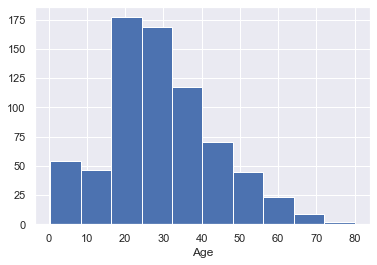

In [29]:
# Histogram distributions Age
plt.hist(df_categories["Age"])
plt.xlabel('Age')

It is right skewed but that is fine will keep the data like this.

Text(0.5, 0, 'Fare')

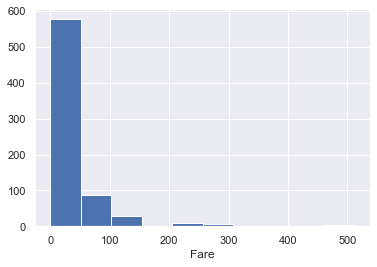

In [30]:
# Histo Fare
plt.hist(df_categories["Fare"])
plt.xlabel('Fare')

Text(0.5, 0, 'Fare')

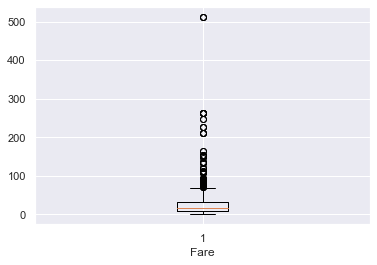

In [31]:
# Boxplot Fare
plt.boxplot(df_categories["Fare"])
plt.xlabel('Fare')

In [32]:
# Remove outliers and keep 95% of data
df_no_outliers = df_categories[df_categories["Fare"] <= df_categories["Fare"]
                               .quantile(0.75)].reset_index(drop=True)
df_no_outliers

,Pclass_2,Pclass_3,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,0,1,0,22.0,0,1,7.2500,0,0
1,0,1,1,26.0,1,1,7.9250,0,1
2,0,1,0,35.0,1,1,8.0500,0,0
3,0,1,0,2.0,0,0,21.0750,0,0
4,0,1,1,27.0,1,0,11.1333,0,1
...,...,...,...,...,...,...,...,...,...
530,0,1,1,39.0,1,0,29.1250,0,0
531,1,0,0,27.0,1,1,13.0000,0,0
532,0,0,1,19.0,1,1,30.0000,0,1
533,0,0,0,26.0,1,1,30.0000,1,1


Text(0.5, 0, 'Fare')

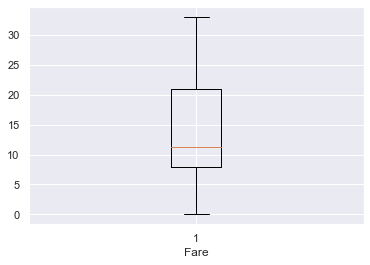

In [33]:
# Boxplot Fare
plt.boxplot(df_no_outliers["Fare"])
plt.xlabel('Fare')

Text(0.5, 0, 'Fare')

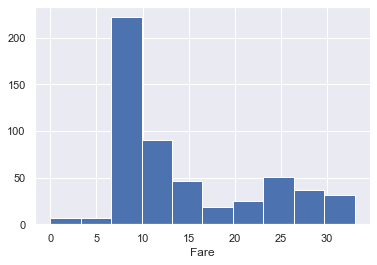

In [34]:
# Histo Fare
plt.hist(df_no_outliers["Fare"])
plt.xlabel('Fare')

This is better but still right skewed. If we chose the 3rd quantile, we will lose more data.

In [35]:
# Last check of preprocess
df_no_outliers.describe()

,Pclass_2,Pclass_3,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
count,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000
mean,0.289720,0.626168,0.321495,28.581776,0.738318,0.786916,14.493877,0.117757,0.334579
std,0.454057,0.484273,0.467488,13.797258,0.439962,0.409870,8.103659,0.322622,0.472285
min,0.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,20.000000,0.000000,1.000000,7.895800,0.000000,0.000000
50%,0.000000,1.000000,0.000000,28.000000,1.000000,1.000000,11.241700,0.000000,0.000000
75%,1.000000,1.000000,1.000000,36.000000,1.000000,1.000000,21.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,80.000000,1.000000,1.000000,33.000000,1.000000,1.000000


In [36]:
# We need to make a function to preprocess the test dataset
def preprocess(df):
    """Preprocess the test data to be able to make prediction"""
    
    # OrdinalEncoder from sklearn
    from sklearn.preprocessing import OrdinalEncoder
    ordinal_enc = OrdinalEncoder()
    
    # Remove columns and NA
    df = df.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis=1)
    df = df.fillna(0) # NA values in test but we can not drop them
    
    # Ordinal encode Embarked feature
    ordinal_enc.fit(np.unique(df['Embarked']).reshape(-1,1)) # For Embarked feature 
    encode_embarked = ordinal_enc.transform(df['Embarked'].values.reshape(-1,1))
    df['Embarked'] = [int(x.item()) for x in encode_embarked]
    
    # Encode and group minority for categorical values
    df = encode_rank_categorical(df, ('Parch', 'SibSp', 'Embarked'))
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    # Dummies Pclas
    dummies = pd.get_dummies(df['Pclass'], drop_first=True)
    df[['Pclass_2', 'Pclass_3']] = dummies
    df = df.drop(['Pclass'], axis=1)
    
    # Reorder cols
    df = df[['Pclass_2', 'Pclass_3', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
                               'Embarked']]
    
    return df

## Machine learning

In [37]:
# Import libraries
from sklearn.preprocessing import StandardScaler

In [38]:
# Init data
train_data = df_no_outliers.copy()
test_data = pd.read_csv('test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [39]:
np.unique(test_data['Parch'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 9]),
 array([324,  52,  33,   3,   2,   1,   1,   2]))

In [40]:
# Preprocess test data
test_data_processed = preprocess(test_data)
test_data_processed.head()

,Pclass_2,Pclass_3,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1,0,34.5,1,1,7.8292,0
1,0,1,1,47.0,0,1,7.0000,0
2,1,0,0,62.0,1,1,9.6875,0
3,0,1,0,27.0,1,1,8.6625,0
4,0,1,1,22.0,0,0,12.2875,0


### Standar scale numeric values

In [41]:
#Init the scaler
scaler = StandardScaler()

In [42]:
# Retrieve features to be scaled from train and test data
unscaled_data_train = train_data[['Age','Fare']]
unscaled_data_test = test_data_processed[['Age','Fare']]
df_train = train_data.drop(['Age','Fare'], axis=1)
df_test = test_data_processed.drop(['Age','Fare'], axis=1)

In [43]:
# Fit scaler on train data
scaler.fit(unscaled_data_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [44]:
# Scale the feature Age and Fare
scaled_train = pd.DataFrame(data = scaler.transform(unscaled_data_train), columns=['Age', 'Fare'])
scaled_test = pd.DataFrame(data = scaler.transform(unscaled_data_test), columns=['Age', 'Fare'])
scaled_test

,Age,Fare
0,0.429344,-0.823198
1,1.336169,-0.925618
2,2.424359,-0.593667
3,-0.114752,-0.720272
4,-0.477482,-0.272524
...,...,...
413,-2.073494,-0.795925
414,0.755801,11.660717
415,0.719528,-0.894739
416,-2.073494,-0.795925


In [45]:
# Concat scaled columns to actual dataframe
df_train_scaled = pd.concat([df_train,scaled_train], axis=1) 
df_test_scaled = pd.concat([df_test,scaled_test], axis=1) 
df_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass_2  418 non-null    uint8  
 1   Pclass_3  418 non-null    uint8  
 2   Sex       418 non-null    int64  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Embarked  418 non-null    int64  
 6   Age       418 non-null    float64
 7   Fare      418 non-null    float64
dtypes: float64(2), int64(4), uint8(2)
memory usage: 20.5 KB


### Check if train label data is balanced

In [46]:
# Count labels in the training set
_, counts = np.unique(df_train_scaled['Survived'], return_counts=True)
counts

array([356, 179])

In [47]:
# Percentage
print('Dead: {:.2f}'.format(counts[0] / df_train_scaled['Survived'].shape[0]))
print('Alive: {:.2f}'.format(counts[1] / df_train_scaled['Survived'].shape[0]))

Dead: 0.67
Alive: 0.33


Our labels are **unbalanced**, so we need to take care of this during the training.

### Feature Selection K Best F-Score

In [48]:
from sklearn.feature_selection import f_classif

In [49]:
# Train set and train labels
x_train = df_train_scaled.drop(['Survived'], axis=1)
y_train = df_train_scaled['Survived']

In [50]:
f_score,p_values = f_classif(x_train, y_train)
summary_table = pd.DataFrame(columns=['Feature'], data=x_train.columns.values)
summary_table['F_score'] = f_score.tolist()
summary_table['p_values'] = p_values.tolist()
summary_table

,Feature,F_score,p_values
0,Pclass_2,20.697821,6.664929e-06
1,Pclass_3,34.428261,7.773756e-09
2,Sex,173.704501,1.554326e-34
3,SibSp,2.227964,1.361240e-01
4,Parch,24.947651,7.996778e-07
5,Embarked,5.100346,2.432455e-02
6,Age,13.072688,3.280801e-04
7,Fare,28.071072,1.714139e-07


The summary table seems to point out that the gender explain a lot about the survival of the people.

### Train model and predict

In [51]:
from sklearn.linear_model import LogisticRegressionCV

In [52]:
# Train the model with hyperparameters
classifier = LogisticRegressionCV(solver='liblinear', penalty='l1', cv=5, random_state=42)
classifier.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l1', random_state=42, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

In [53]:
# Check score of prediction on training
classifier.score(x_train, y_train)

0.8074766355140187

In [54]:
result = classifier.predict(df_test_scaled)
test_data['Survived'] = result.tolist()
response = test_data[['PassengerId', 'Survived']]
response

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [55]:
# Save result
response.to_csv('submission.csv', index=False)

## Modification
1. Change the outliers **quantile limit** for Fare to 0.75 (improve to 0.8 for training prediction)
2. Change **mapping method** and using **OrdinalEncoder** for Embarked (improve to 0.803)
3. **Hyperparameter in LogR** (solver:'liblinear', class_weight:'balanced', random_state:42) (decrease to 0.78)
4. Change to Ensemble method **GradientBoostingClassification** (improve to 0.9 training but test is 0.67)
5. Comming back to LogR and submit **(test score : 0.75 > 0.73)**
6. LogisticRegressionCV(solver='liblinear', penalty='l1', cv=5, random_state=42) **(test score: 076)**